In [1]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
batch_size = 512

nz = 100 
ngf = 32 
ngpu = 1

niter = 10

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label):
    """
    Args:
    
    Returns:
    
    """
    
    t = torch.zeros(10)
    t[target_label] = 1.0
    
    return t.to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [8]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

/tmp/ipykernel_2146329/58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

Number of parameters: 3,573,696
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bia

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            # nn.Conv2d(1, 1, 2, 2, 0, bias=False),
            # nn.BatchNorm2d(1),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(1, 1, 2, 2, 0, bias=False),
            # nn.BatchNorm2d(1),
            nn.Flatten(),
            #FuzzyLayer.from_dimensions(9, 10),
            nn.Linear(16, 2),
            #nn.BatchNorm1d(2),
            #DefuzzyLinearLayer.from_dimensions(100, 1, with_norm=False)
            
            #DefuzzyLinearLayer.from_dimensions(20, 1, with_norm=False)
            #nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid()
        )
        self.latent_dim = 2
        self.fuzzlets = 10
        theta = np.linspace(0, 2*np.pi, self.fuzzlets+1)
        a, b = 1.5 * np.cos(theta), 1.5 * np.sin(theta)

        self.core = nn.Sequential(
            FuzzyLayer.from_centers([[x[0],x[1]] for x in zip(a,b)][:-1]),
            #nn.BatchNorm1d(self.fuzzlets),
            #nn.Linear(self.fuzzlets, 1, bias=False)
            #DefuzzyLinearLayer.from_dimensions(self.fuzzlets, 1, with_norm=False)
        )
        #self.real = nn.Sequential(
        #    FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzlets)
        #)
        #self.core[0].set_requires_grad_rot(False)
        #self.core[0].set_requires_grad_rot(False)
        #self.fake[0].set_requires_grad_rot(False)

    def forward(self, input):
        output = self.main(input)
        c = self.core(output)
        
        return c.sum(-1), 0
    
    # def forward2(self, input):
    #     batch_size = input.shape[0]
    #     output = self.main(input)
    #     c = self.core(output)
        
    #     centroids_c = self.core[0].centroids.squeeze(-1)

    #     с_winners = torch.randint(0, self.fuzzlets, (batch_size, )).to(device)
    #     centroids_c = centroids_c[с_winners]
        
    #     c = c.gather(1, с_winners.reshape((batch_size, 1))).squeeze()    
    #     return c, (output - centroids_c).abs().sum(-1)
    
    def freeze_encoder(self):
        #self.core[0].set_requires_grad_rot(False)
        self.main.requires_grad_(False)
    
    def arate(self, input):
        return self.forward(input)[0]
    

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 658,262
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16, out_features=2, bias=True)
  )
  (core): Sequential(
    (0): FuzzyLayer(
      

In [12]:
inp = torch.rand(13, 1, 28, 28).to(device)
dd = Discriminator(1).to(device)
dd(inp)

(tensor([2.3052, 2.2538, 2.3025, 2.3655, 2.2955, 2.3088, 2.2780, 2.2368, 2.2634,
         2.2559, 2.2993, 2.3585, 2.3785], device='cuda:0',
        grad_fn=<SumBackward1>),
 0)

## Train

In [13]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.001, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [14]:
def keep_eigenvals_positive_loss(d, eps = 1e-1):
    ev = d.core[0].get_transformation_matrix_eigenvals().real.min()
    ev = torch.where(ev > eps, eps, ev)
    return -ev

In [15]:
def get_test_arate_distr(D):
    firing_levels = []
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = D.arate(data)
            firing_levels.append(rates.cpu().numpy())
            

    firing_levels = np.concatenate(firing_levels, axis=0)
    for p in firing_levels:
        lab_true.append(1)
        lab_pred.append(p)

    with torch.no_grad():
        for data, labels in tqdm(emnist_loader, desc='Test EMNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D.arate(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                
    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)

    return firing_levels, roc_auc

def draw_embeddings(epoch):
    #centroids_r = netD.real[0].centroids.squeeze(-1).cpu().detach().numpy()
    #centroids_f = netD.fake[0].centroids.squeeze(-1).cpu().detach().numpy()
    centroids_core = netD.core[0].centroids.squeeze(-1).cpu().detach().numpy()
    
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    embedings_fake = []

    with torch.no_grad():
        batch_size = 256
        latent_size = 100
        
        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        if torch.cuda.is_available():
            fixed_noise = fixed_noise.cuda()
        fake_images = netG(fixed_noise)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

    embedings_fake = np.concatenate(embedings_fake, axis=0)    

    fig = plt.figure(figsize=(6, 6))
    R, C = 1, 1
    cnt = 1
    for i in range(1):
        plt.subplot(R, C, cnt)
        cnt += 1
        plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=16)
        plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
        #plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='X', c='green', s= 64)
        #plt.scatter(centroids_f[:,2*i], centroids_f[:,2*i+1], marker='o', c='red', s= 16)
        plt.scatter(centroids_core[:,2*i], centroids_core[:,2*i+1], marker='*', c='blue', s= 128)
        
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
    #plt.colorbar()
    plt.show()
    writer.add_figure('Embeddings', fig, epoch)

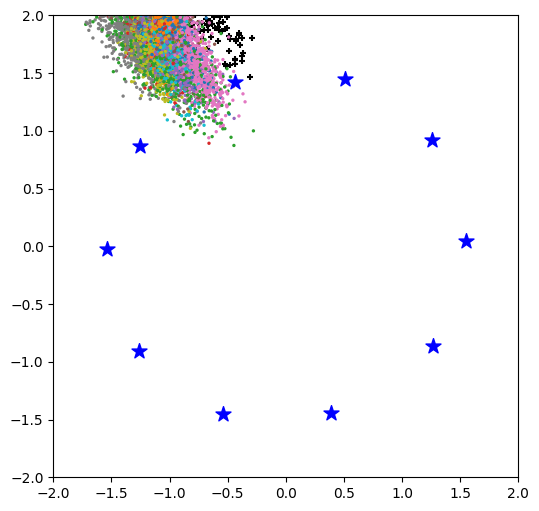

Epoch 0/10
{'EV': -0.10000000149011612, 'D': 0.9121724278745005, 'G': 0.31244940091204687}


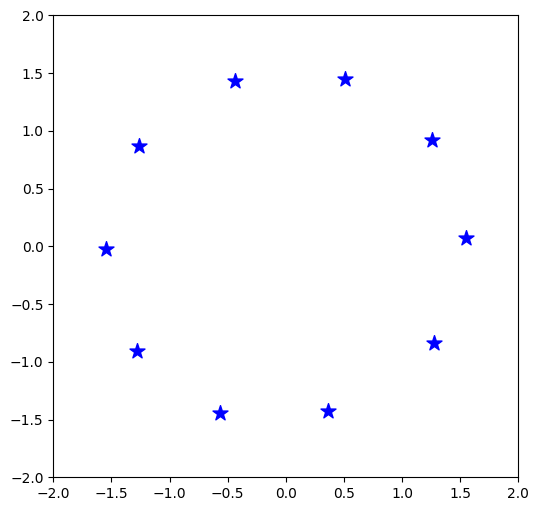

Epoch 1/10
{'EV': -0.10000000149011612, 'D': 0.30325168614291537, 'G': 0.6334104886499502}


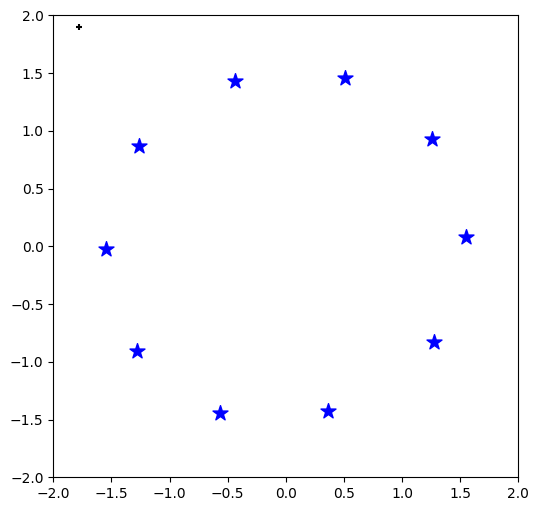

Epoch 2/10
{'EV': -0.10000000149011612, 'D': 0.41558054702009184, 'G': 0.6176869753053633}


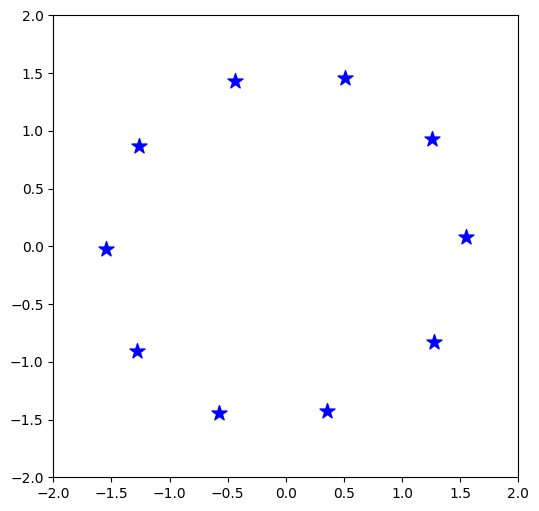

Epoch 3/10
{'EV': -0.10000000149011612, 'D': 0.5374242400718947, 'G': 0.47218565920651967}


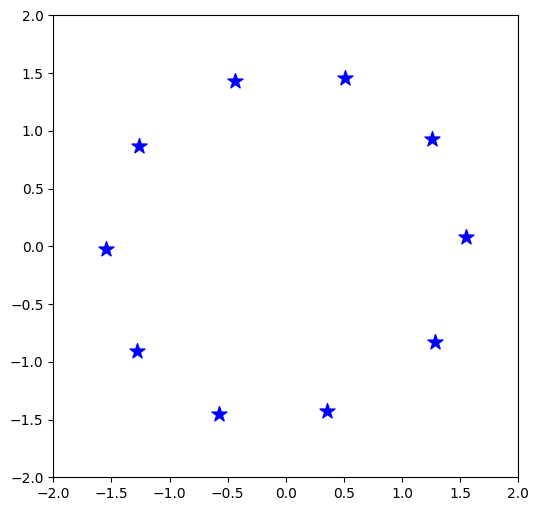

Epoch 4/10
{'EV': -0.10000000149011612, 'D': 0.5492227193662675, 'G': 0.3399082745535899}


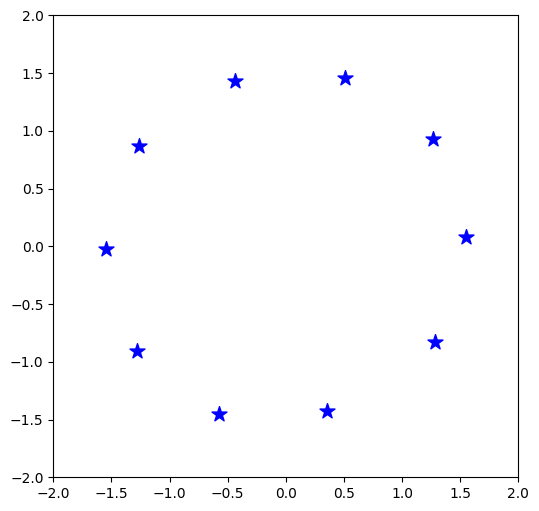

Epoch 5/10
{'EV': -0.10000000149011612, 'D': 0.5360937992394981, 'G': 0.2986988642458188}


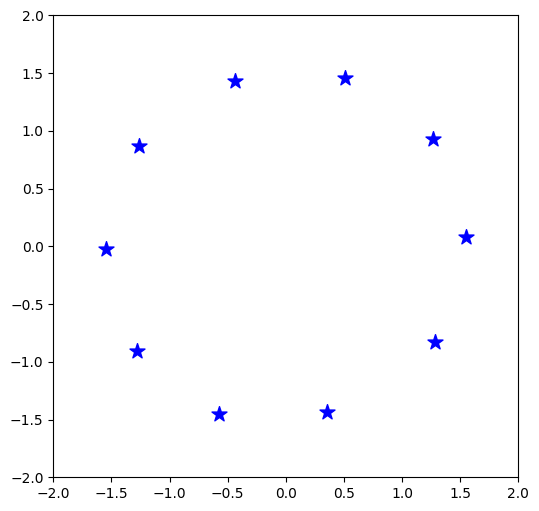

Epoch 6/10
{'EV': -0.10000000149011612, 'D': 0.5277757301168927, 'G': 0.28370326959480674}


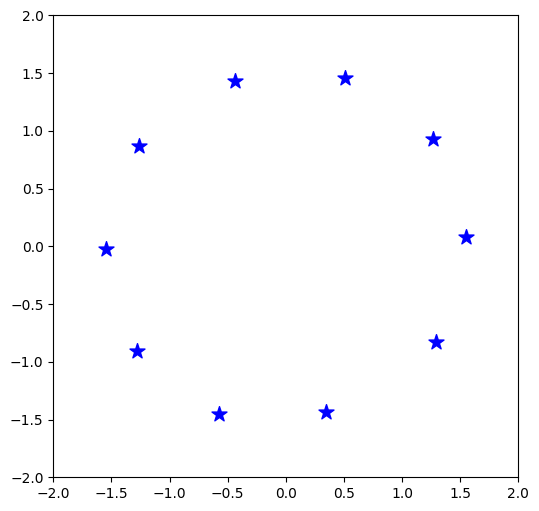

Epoch 7/10
{'EV': -0.10000000149011612, 'D': 0.5223539289781602, 'G': 0.27668247384540107}


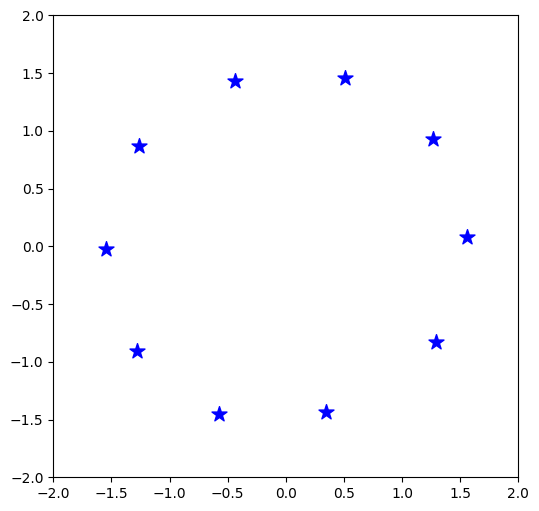

Epoch 8/10
{'EV': -0.10000000149011612, 'D': 0.5193333736920761, 'G': 0.2728675184613567}


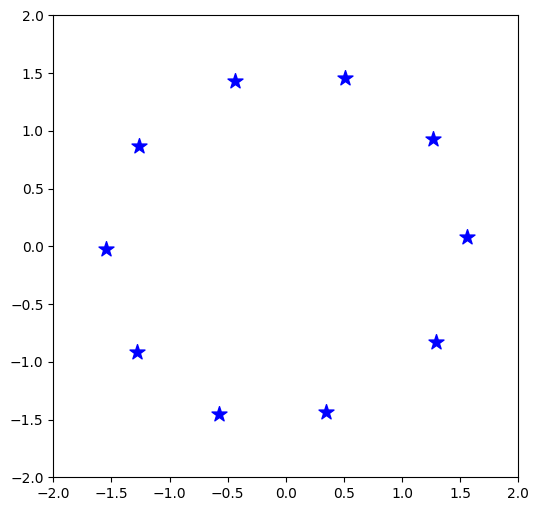

Epoch 9/10
{'EV': -0.10000000149011612, 'D': 0.5171892940998077, 'G': 0.26987883297063536}


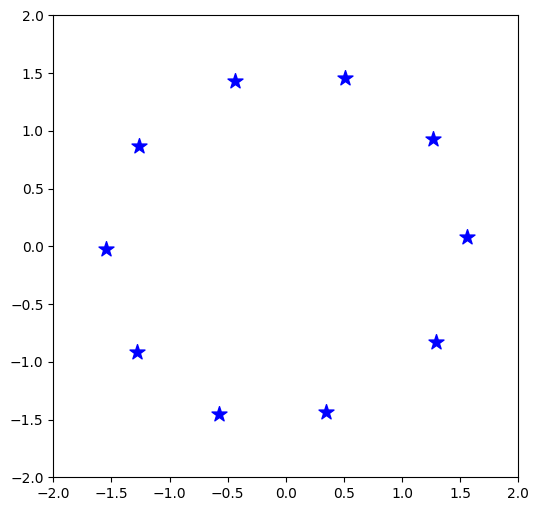

In [16]:
for epoch in range(niter):

    netG.train()
    netD.train()
    report_loss_G = 0
    report_loss_D = 0
    report_loss_EV = 0
    local_count = 0
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        
        # train with real
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        # netD.zero_grad()
        # core, dists_c, _, _ = netD(real_cpu)
        # dists_c.mean().backward()
        # optimizerD.step()
        
        netD.zero_grad()
        core,_ = netD(real_cpu)
        errD_real = torch.square(core - 1).mean()
        errD_real.backward(retain_graph=True)
        ev_loss_r = keep_eigenvals_positive_loss(netD)
        ev_loss_r.backward()
        optimizerD.step()
        
        #train with fake
        netD.zero_grad()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        core,_ = netD(fake.detach())
        errD_fake = torch.square(core).mean()
        errD_fake.backward(retain_graph=True)
        ev_loss_f = keep_eigenvals_positive_loss(netD)
        ev_loss_f.backward()
        optimizerD.step()
        
        #adjust sattelite
        #netD.zero_grad()
        # _, _, p, dp = netD(real_cpu)
        # dp.mean().backward()
        # optimizerD.step()
        
        #inp = torch.cat((fake.detach(), real_cpu))
        #target = torch.cat((torch.zeros(batch_size), torch.ones(batch_size))).to(device)
        
        # netD.zero_grad()
        # _, _, p, _ = netD(inp)
        # (torch.square(target - p).mean()).backward()
        # optimizerD.step()
        
        errD = errD_real + errD_fake
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        netD.zero_grad()
        
        core,_ = netD(fake)
        errG = torch.square(core - 1).mean()
        errG.backward()
        
        optimizerG.step()

        report_loss_G += errG.item()

        local_count += 1
        report_loss_D += errD.item()
        report_loss_EV += torch.max(ev_loss_f, ev_loss_r).item()
        
    netG.eval()
    netD.eval()

    losses = {}
    
    losses['EV'] = report_loss_EV / local_count
    losses['D'] = report_loss_D / local_count
    losses['G'] = report_loss_G / local_count
    writer.add_scalars('Loss', losses, epoch)
    fake = netG(fixed_noise)
    writer.add_images('Generated images', fake.detach(), epoch)
    draw_embeddings(epoch)    
    #mnist_distr, auc = get_test_arate_distr(netD)
    #mnist_distr_q = {}
    #mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
    #mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
    #writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
    #writer.add_scalar("AUC", auc, epoch)
    print(f"Epoch {epoch}/{niter}")
    print(losses)

draw_embeddings(epoch)
num_gpu = 1 if torch.cuda.is_available() else 0

In [17]:
netD.core[0].get_transformation_matrix()

tensor([[[ 0.9980, -0.0494, -1.5452],
         [-0.0494,  1.0544, -0.0251],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0844, -0.0828, -1.2812],
         [-0.0828,  1.0649, -0.9111],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1235, -0.1290, -0.5767],
         [-0.1290,  1.0912, -1.4563],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1339, -0.1524,  0.3461],
         [-0.1524,  1.0705, -1.4314],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9071, -0.0456,  1.2949],
         [-0.0456,  1.1700, -0.8261],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9763, -0.1042,  1.5556],
         [-0.1042,  1.1428,  0.0843],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0236, -0.0709,  1.2638],
         [-0.0709,  1.1121,  0.9276],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0515, -0.0640,  0.5082],
         [-0.0640,  1.0607,  1.4546],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0424, -0.0444, -0.4373],
         [-0.0444,  1.0411,  1.428

In [18]:
netD.core[0].get_transformation_matrix_eigenvals()

tensor([[0.9693+0.j, 1.0830+0.j],
        [1.1580+0.j, 0.9912+0.j],
        [1.2373+0.j, 0.9774+0.j],
        [1.2579+0.j, 0.9465+0.j],
        [0.8995+0.j, 1.1777+0.j],
        [0.9262+0.j, 1.1929+0.j],
        [0.9843+0.j, 1.1514+0.j],
        [0.9919+0.j, 1.1203+0.j],
        [1.0861+0.j, 0.9973+0.j],
        [0.9763+0.j, 1.0615+0.j]], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)

In [19]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.002, betas=(0.5, 0.999))

In [20]:
# netG.eval()
# netD.freeze_encoder()


# for epoch in range(niter):
   
#     netD.train()
#     report_loss_D = 0
#     report_loss_Rad = 0
#     report_loss_EV = 0.0
#     local_count = 0
#     for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        
#         # train with real
#         real_cpu = data[0].to(device)
#         batch_size = real_cpu.size(0)
        
#         #netD.zero_grad()
#         #_, dist = netD.forward2(real_cpu)
#         #dist.abs().mean().backward()
#         #optimizerD.step()
        
#         noise = torch.randn(batch_size, nz, 1, 1, device=device)
#         fake = netG(noise)
        
#         inp = torch.cat((fake.detach(), real_cpu))
#         target = torch.cat((torch.zeros(batch_size), torch.ones(batch_size))).to(device)
        
#         netD.zero_grad()
#         firing, dist = netD(inp)
#         # _, _, p, _ = netD(inp)
#         #d = torch.where(dist>1, dist, 0.1)
#         errD = (torch.square(target - firing).mean()) #+ d.mean()
#         errD.backward(retain_graph=True)
#         ev_loss = keep_eigenvals_positive_loss(netD)
#         ev_loss.backward()
#         optimizerD.step()
        
#         # netD.zero_grad()
#         # firing, dist = netD.forward2(real_cpu)
#         # errD_real = torch.square(firing - 1).mean()
#         # errD_real.backward()
#         # optimizerD.step()
        
#         # #train with fake
#         # netD.zero_grad()
        
#         # firing, _ = netD.forward2(fake.detach())
#         # errD_fake = torch.square(firing).mean()
#         # errD_fake.backward()
#         # optimizerD.step()
        
#         #errD = errD_real + errD_fake
        
#         local_count += 1
#         #report_loss_Rad += dist.mean().item()
#         report_loss_D += errD.item()
#         if ev_loss.item() > report_loss_EV:
#             report_loss_EV = ev_loss.item()
        
#     netG.eval()
#     netD.eval()

#     losses = {}
    
#     losses['Adjusting D'] = report_loss_D / local_count
#     losses['Adjusting Rad'] = report_loss_Rad / local_count
#     losses['EV'] = report_loss_EV
    
    
#     writer.add_scalars('Loss', losses, epoch)
#     draw_embeddings(epoch)    
#     #mnist_distr, auc = get_test_arate_distr(netD)
#     #mnist_distr_q = {}
#     #mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
#     #mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
#     #writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
#     #writer.add_scalar("AUC", auc, epoch)
#     print(f"Epoch {epoch}/{niter}")
#     print(losses)

## Валидация

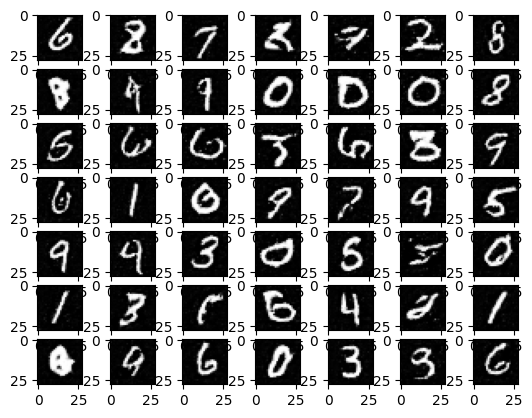

In [21]:
D = netD
G = netG
D.eval()
G.eval()

with torch.no_grad():
    batch_size = 49
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(batch_size):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

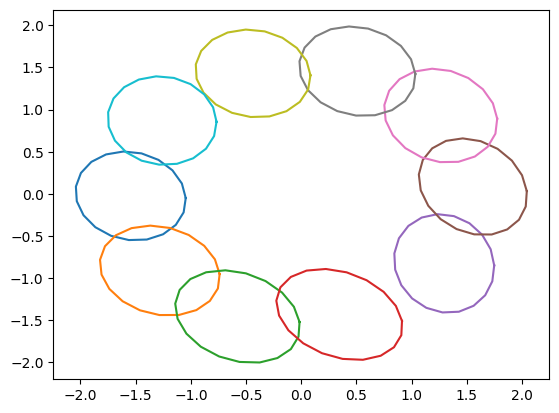

In [22]:
A = netD.core[0].get_transformation_matrix().detach().cpu().numpy()

theta = np.linspace(0, 2*np.pi, 20)
a, b = 0.5 * np.cos(theta), 0.5 * np.sin(theta)

for i in range(A.shape[0]):
    h = A[i]
    t = [np.matmul(h, [x[0], x[1], 1]) for x in zip(a,b)]
    t = np.array(t)
    plt.plot(t[:, 0], t[:, 1])
    
plt.show()
#c_real = lambda x: D.real(torch.FloatTensor([x]).to(device)).max(1).values.detach().cpu().item()
#c_core = lambda x: D.core(torch.FloatTensor([x]).to(device)).max(1).values.detach().cpu().item()
#f = lambda x: [[c_core(a), 0, 0] for a in x]

#xy = np.mgrid[-2:2:200j, -2:2:200j].reshape(2,-1).T

#img = np.reshape(f(xy),(200,200,3))
#plt.figure(figsize=(6, 6))
#plt.imshow(img, extent=[-2,2,-2,2])
#plt.show()

In [23]:
A[0]

array([[ 0.99800736, -0.04938745, -1.545198  ],
       [-0.04938745,  1.0543602 , -0.02512891],
       [ 0.        ,  0.        ,  1.        ]], dtype=float32)

In [24]:
def get_arate(inp):
    return D(inp)[0]
get_arate(inp.to(device))

tensor([0.2373, 0.1952, 0.2478, 0.2498, 0.1700, 0.2308, 0.2725, 0.2219, 0.2429,
        0.2213, 0.2251, 0.1872, 0.2051], device='cuda:0',
       grad_fn=<SumBackward1>)

In [25]:
centroids_r = D.core[0].centroids.squeeze(-1).cpu().detach().numpy()
#centroids_f = D.fake[0].centroids.squeeze(-1).cpu().detach().numpy()
#centroids_r

In [26]:
D.core[0].get_transformation_matrix()

tensor([[[ 0.9980, -0.0494, -1.5452],
         [-0.0494,  1.0544, -0.0251],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0844, -0.0828, -1.2812],
         [-0.0828,  1.0649, -0.9111],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1235, -0.1290, -0.5767],
         [-0.1290,  1.0912, -1.4563],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1339, -0.1524,  0.3461],
         [-0.1524,  1.0705, -1.4314],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9071, -0.0456,  1.2949],
         [-0.0456,  1.1700, -0.8261],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9763, -0.1042,  1.5556],
         [-0.1042,  1.1428,  0.0843],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0236, -0.0709,  1.2638],
         [-0.0709,  1.1121,  0.9276],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0515, -0.0640,  0.5082],
         [-0.0640,  1.0607,  1.4546],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0424, -0.0444, -0.4373],
         [-0.0444,  1.0411,  1.428

In [27]:
D.core[0].get_transformation_matrix_eigenvals()

tensor([[0.9693+0.j, 1.0830+0.j],
        [1.1580+0.j, 0.9912+0.j],
        [1.2373+0.j, 0.9774+0.j],
        [1.2579+0.j, 0.9465+0.j],
        [0.8995+0.j, 1.1777+0.j],
        [0.9262+0.j, 1.1929+0.j],
        [0.9843+0.j, 1.1514+0.j],
        [0.9919+0.j, 1.1203+0.j],
        [1.0861+0.j, 0.9973+0.j],
        [0.9763+0.j, 1.0615+0.j]], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)

In [28]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

Encoding:   0%|          | 0/20 [00:00<?, ?it/s]

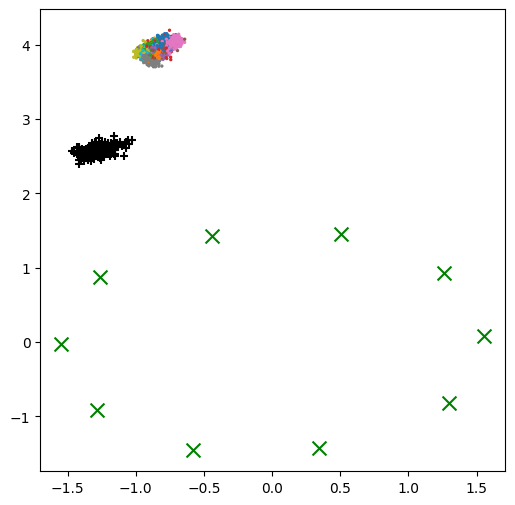

In [29]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 6))

R, C = 1, 1
cnt = 1
for i in range(1):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='green', s= 100)
    #plt.scatter(centroids_f[:,2*i], centroids_f[:,2*i+1], marker='o', c='red', s= 20)
    #plt.xlim(-0.5, 0.5)
    #plt.ylim(-0.5, 0.5)
#plt.colorbar()
plt.show()



Encoding:   0%|          | 0/203 [00:00<?, ?it/s]

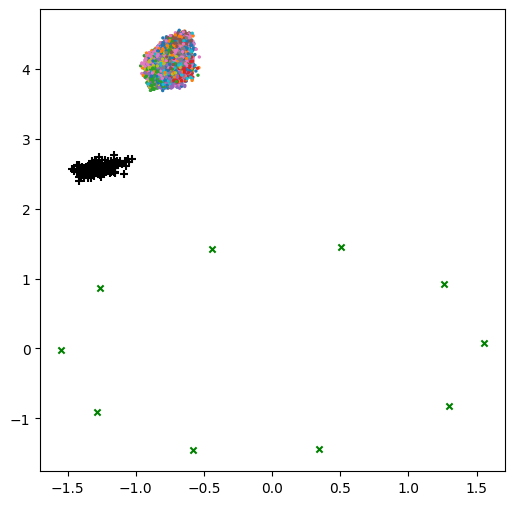

In [30]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 6))

R, C = 1, 1
cnt = 1
for i in range(1):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='green', s= 20)
    #plt.scatter(centroids_f[:,2*i], centroids_f[:,2*i+1], marker='o', c='red', s= 20)
    #plt.xlim(-0.5, 0.5)
    #plt.ylim(-0.5, 0.5)
#plt.colorbar()
plt.show()

Encoding:   0%|          | 0/20 [00:00<?, ?it/s]

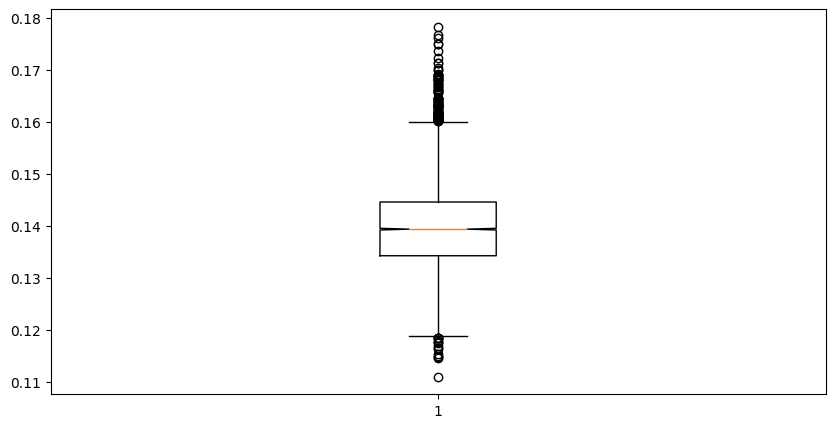

In [31]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #rates = r

        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [32]:
firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #arate = 1 - r.sum(dim = 1)
        
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/203 [00:00<?, ?it/s]

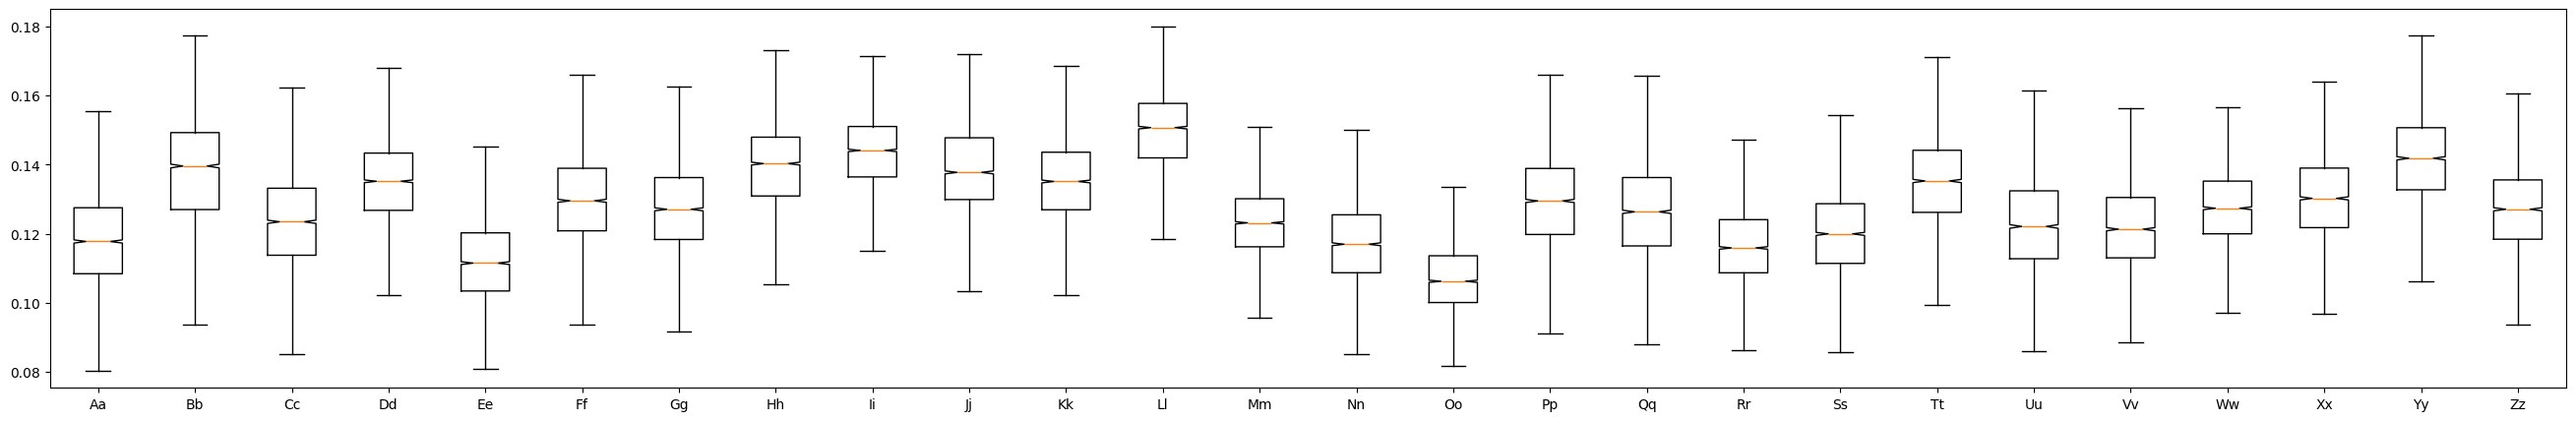

In [33]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

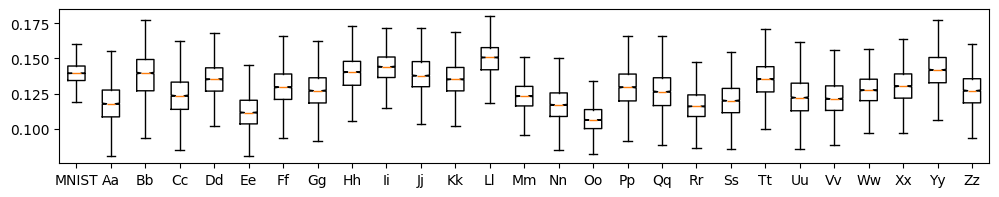

In [34]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

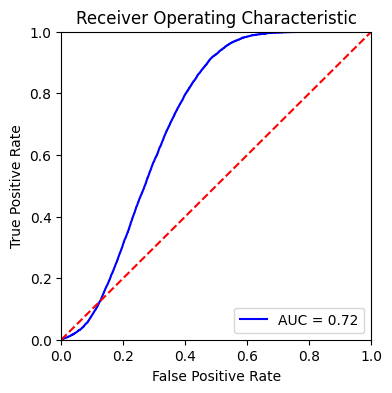

In [35]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)